In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import math
from sklearn.cluster import KMeans
from sklearn.cluster import kmeans_plusplus
from matplotlib import cm

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Classes and functions

In [2]:
# this is basically everything that happens 'client-side'
class client():
    def __init__(self, data, n_centroids):
        self.data = data
        #self.n_centroids = n_centroids
        self.means = np.zeros((n_centroids, 2))
        self.n_c_local = 0
    def predict_means(self, global_centers):
        
        local_centers = self.det_new_local_centers(global_centers)
        #print(local_centers.shape)
        km = KMeans(n_clusters = self.n_c_local, init = local_centers, max_iter = 1).fit(self.data)
        mean_vals = np.copy(km.cluster_centers_)
        self.means = np.copy(km.cluster_centers_)
        samples = self.calc_cluster_amts(km)
        
        # safety check in case we send a single sample values back as a mean
        inds = np.where(samples == 1)
        mask = np.ones_like(samples, dtype = bool)
        mask[inds] = False
        samples = samples[mask]
        mean_vals = mean_vals[mask]

        return mean_vals, km.score(self.data), samples
                                
    def calc_cluster_amts(self, km):
        return np.array([len(km.labels_[km.labels_ == i]) for i in range(self.n_c_local)])
        
    def det_new_local_centers(self, global_centers):
        #simple option: calculate distances from data mean
        dmean = np.mean(self.data, axis = 0)
        #print(global_centers, dmean)
        dists = np.linalg.norm(global_centers - dmean, axis = 1)
        dist_inds = np.argsort(dists)
        
        gcenter_mat = np.array([global_centers for i in range(self.n_c_local)])
        #lcenter_mat = np.array([self.means for i in range(global_centers.shape[0])])
        return global_centers[dist_inds[0:self.n_c_local]]
  
    
    def calc_cluster_distance(self, local_clusters):
        # output: a n-1 by n-1 array of distances (could make it n by n with diagonal 0)
        a = np.zeros((local_clusters.shape[0], local_clusters.shape[0]))
        # this is super unoptimized but w/e
        for i in range(local_clusters.shape[0]):
            for j in range(local_clusters.shape[0]):
                a[i,j] = np.linalg.norm(local_clusters[i,:] -  local_clusters[j,:])
        return a   
    
    def init_local_clusters(self, n_cluster_g, alpha, xmin, xmax, ymin, ymax):

        pre_threshold = math.sqrt(((xmin - xmax) * (ymin - ymax))) / n_cluster_g
        thr = pre_threshold * alpha

        local_cluster_amt = n_cluster_g

        for j in range(n_cluster_g - 1):
                clusters_l, _  = kmeans_plusplus(self.data, local_cluster_amt)
                a = self.calc_cluster_distance(clusters_l)
                if (a<thr).sum() > local_cluster_amt:
                    local_cluster_amt -= 1
                else:
                    break
        self.n_c_local = local_cluster_amt          
        local_clusters, _ = kmeans_plusplus(self.data, local_cluster_amt)
        
        return local_clusters

In [3]:
#'server-side' implementation
class server():
    def __init__(self, n_clusters):
        self.n_clusters = n_clusters
            
    def aggregate(self, means, samples):
        
        cluster_aggregator = KMeans(n_clusters = self.n_clusters)
        avg_means = np.zeros((self.n_clusters, 2))
        
        means_res = means.reshape((-1,2))
        #cluster_aggregator.fit(means_res, sample_weight =  samples.reshape(-1))
        cluster_aggregator.fit(means_res, sample_weight = samples)
        
        return cluster_aggregator.cluster_centers_
                         

In [4]:
#to run everything smoothly
def run(clients, server, crounds, nclients, n_cluster_global , alpha, Xmin, Xmax, Ymin, Ymax):
    
    #initialize: determine local amount of clusters, and give initial local cluster means
    for client_i, client in enumerate(clients):
        init_clusters_local = client.init_local_clusters(n_cluster_global, alpha, Xmin, Xmax, Ymin, Ymax)
        if client_i == 0:
            init_clusters = init_clusters_local
        else:
            init_clusters = np.concatenate((init_clusters, init_clusters_local))
        #print(init_clusters.shape)
    
    local_clusters = init_clusters
    samples = np.ones(local_clusters.shape[0])

    # communication loop
    for r in range(crounds - 1):
        # central aggregation
        global_clusters = server.aggregate(local_clusters, samples)
        
        #local cluster selection and kmeans
        for client_i, client in enumerate(clients):
            # this function first determines which global clusters to select, and then does local kmeans with those
            local_cluster, _, sample = client.predict_means(global_clusters)
            print(local_cluster.shape)
            #client concatenation 'at the server'
            if client_i == 0:
                local_clusters = local_cluster
                samples = sample
            else:
                local_clusters = np.concatenate((local_clusters, local_cluster), axis = 0)
                samples = np.concatenate((samples, sample), axis = 0)
        #print(local_clusters.shape, samples.shape)
    #One final aggregation
    global_clusters =  server.aggregate(local_clusters, samples)

    return global_clusters   

## Loading data

In [5]:
# read datasets, create one full dataset for central baseline as well
cwd = os.getcwd()

#this one will be used for assigning data to a client
datafiles = [cwd + "/data/cluster_client" + str(i) + ".csv" for i in range(5)] 

#create full dataset for comparison
for i, file in enumerate(datafiles):
    data = np.genfromtxt(datafiles[i], delimiter=',')
    #print(data.shape)
    if i == 0:
        data_full = data
    else:
        data_full = np.concatenate((data, data_full), axis = 0)

## Federated run

In [6]:
n_clients = 5
n_cluster_global = 16
crounds = 5

alpha = 1
Xmin = -12.5
Xmax = 12.5
Ymin = -12.5
Ymax = 12.5
# init clients and server
clients = [client(np.genfromtxt(datafiles[i], delimiter=','), n_cluster_global) for i in range(n_clients)]
server_obj = server(n_cluster_global)

means_federated = run(clients, server_obj, crounds, n_clients, n_cluster_global, alpha, Xmin, Xmax, Ymin, Ymax)

(13, 2)
(6, 2)
(8, 2)
(4, 2)
(8, 2)
(13, 2)
(6, 2)
(9, 2)
(5, 2)
(9, 2)
(13, 2)
(6, 2)
(8, 2)
(5, 2)
(9, 2)
(13, 2)
(6, 2)
(9, 2)
(5, 2)
(8, 2)


## Central baseline

In [7]:
kmeans_cent = KMeans(n_clusters = 16, random_state=0).fit(data_full)

## Visualization

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


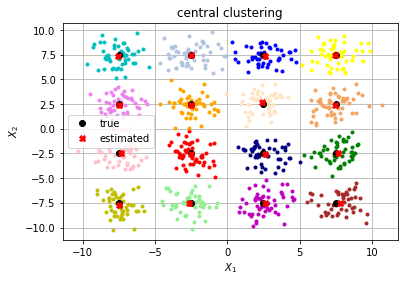

In [9]:
colors = ['r', 'b', 'g', 'c', 'm', 'y', 'orange', 'brown',
          'pink', 'navy', 'lightsteelblue', 'bisque', 'yellow', 'lightgreen', 'violet', 'sandybrown']

means_original = np.array([[-7.5, -7.5, -7.5, -7.5, -2.5, -2.5, -2.5, -2.5, 2.5, 2.5, 2.5, 2.5, 7.5, 7.5, 7.5, 7.5],
                           [-7.5, -2.5, 2.5, 7.5, -7.5, -2.5, 2.5, 7.5, -7.5, -2.5, 2.5, 7.5, -7.5, -2.5, 2.5, 7.5]])

for point_i in range(data_full.shape[0]):
    plt.plot(data_full[point_i,0], data_full[point_i,1],'.', color=colors[kmeans_cent.labels_[point_i]])
    
plt.plot(means_original[0,:], means_original[1,:],"o", color="black", label = "true")
plt.plot(kmeans_cent.cluster_centers_[:,0], kmeans_cent.cluster_centers_[:,1], "X", color="red", label="estimated")
plt.legend()
plt.title("central clustering")
plt.grid(True)
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.savefig("central_results.eps", format="eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


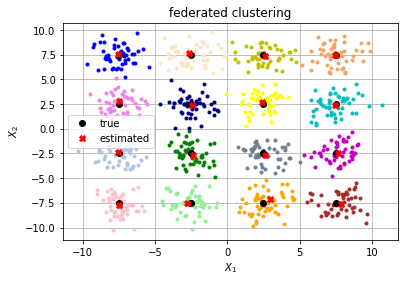

In [12]:
# make an extra 'kmeans' object for visualization
server_kmeans = KMeans(n_clusters=16, ).fit(clients[1].data) #need fit before predict
server_kmeans.cluster_centers_ = np.copy(means_federated)# overwrite the 'fit' results

predict_labels = server_kmeans.predict(data_full) #these are used for visualization

colors = ['b', 'g', 'c', 'm', 'y', 'orange', 'brown',
          'pink', 'navy', 'lightsteelblue', 'bisque', 'yellow', 'lightgreen', 'violet', 'sandybrown', 'slategrey']



for point_i in range(data_full.shape[0]):
    plt.plot(data_full[point_i,0], data_full[point_i,1],'.', color=colors[predict_labels[point_i]])
    
plt.plot(means_original[0,:], means_original[1,:],"o", color="black", label = "true")
plt.plot(means_federated[:,0], means_federated[:,1], "X", color="red", label="estimated")
plt.legend()
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.title("federated clustering")
plt.grid(True)
plt.savefig("federated_results.eps", format="eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


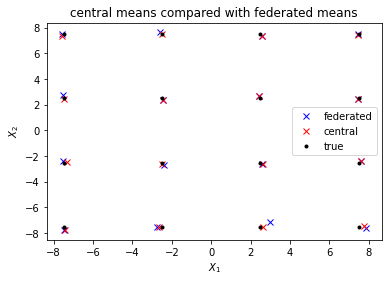

In [13]:
plt.plot(means_federated[:,0], means_federated[:,1],"x", color="blue", label = "federated")
plt.plot(kmeans_cent.cluster_centers_[:,0], kmeans_cent.cluster_centers_[:,1], "x", color="red", label="central")
plt.plot(means_original[0,:], means_original[1,:],".", color="black", label = "true")

plt.title("central means compared with federated means")
plt.legend()
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.savefig("federated_means.eps", format="eps")

Text(0.5, 1.0, 'federated vs. original')

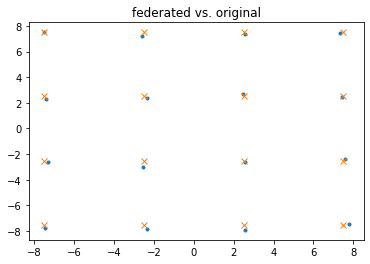

In [160]:
means_original = np.array([[-7.5, -7.5, -7.5, -7.5, -2.5, -2.5, -2.5, -2.5, 2.5, 2.5, 2.5, 2.5, 7.5, 7.5, 7.5, 7.5],
                           [-7.5, -2.5, 2.5, 7.5, -7.5, -2.5, 2.5, 7.5, -7.5, -2.5, 2.5, 7.5, -7.5, -2.5, 2.5, 7.5]])

plt.plot(global_clusters[:,0], global_clusters[:,1], '.')
plt.plot(means_original[0,:], means_original[1,:], 'x')
plt.title("federated vs. original")